<a href="https://colab.research.google.com/github/abhi-11nav/Text-Emotion-Detection/blob/main/Text_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Importing the necessary libraries 

import pandas as pd
import numpy as np 

In [9]:
!git clone https://github.com/abhi-11nav/Text-Emotion-Detection.git

Cloning into 'Text-Emotion-Detection'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 70 (delta 44), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (70/70), done.


In [10]:
# Importing data

data = pd.read_csv("/content/Text-Emotion-Detection/tweet_emotions.csv")

In [11]:
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


Funeral ceremony...gloomy friday...

In [12]:
# Let us drop the tweet id

data.drop("tweet_id", axis=1, inplace=True)

In [13]:
data.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [14]:
# Let us check if the tweet has any missing values 

data.isna().any()

sentiment    False
content      False
dtype: bool

No missing values

In [15]:
# Let us check the number of categories in sentiment variable

data['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

Since the data is imbalanced, we'll be deadling with it 

Data Imbalance

### Eliminating the last two categories of sentiment as they are least represented. 

In [16]:
# dropping the last two samples

# Appending indexes to remove
indexes_to_remove = []


for index in data[data['sentiment']=="boredom"].index:
  indexes_to_remove.append(index)

for index in data[data['sentiment']=="anger"].index:
  indexes_to_remove.append(index)

In [17]:
len(indexes_to_remove)

289

In [18]:
data.drop(indexes_to_remove, inplace=True, axis=0)

In [19]:
data["sentiment"].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
Name: sentiment, dtype: int64

In [20]:
labels = [label for label in data["sentiment"].unique()]

In [21]:
balanced_df = pd.DataFrame()

for label in labels: 
  balanced_df = pd.concat([data[data["sentiment"]==label].sample(759),balanced_df], axis=0)

In [22]:
balanced_df["sentiment"].value_counts()

relief        759
happiness     759
hate          759
fun           759
love          759
surprise      759
worry         759
neutral       759
enthusiasm    759
sadness       759
empty         759
Name: sentiment, dtype: int64

 Now we have a balanced dataset

In [23]:
# shuffling samples and resetting indexes

balanced_df = balanced_df.sample(len(balanced_df))

In [24]:
balanced_df.reset_index(inplace=True)

In [25]:
balanced_df.head()

,index,sentiment,content
0,970,hate,feeling really sick watching the fifth elemen...
1,39504,hate,"@GeminiAngel24 lol, my current mp3 player is a..."
2,11331,neutral,@lorenatierra I'll be back home on Monday.
3,26476,love,"@mamalou52 I love Puerto Rico also,been all ov..."
4,28506,happiness,Happy Star Wars Day. MAY THE 4TH BE WITH YOU


In [26]:
balanced_df.drop("index", inplace=True, axis=1)

In [27]:
# Changing the name of the data frame

data = balanced_df

In [28]:
# Let us look at the sentences

data['content'][0]

'feeling really sick  watching the fifth element, and about to smoke a cigg. ugh i hate colds!'

In [29]:
data['content'][1]

'@GeminiAngel24 lol, my current mp3 player is a brick. It would be nice to have something slim'

Text Preprocessing

In [30]:
# Importing libraries

import re 

import nltk 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [31]:
def text_preprocess(dataset,list_name):
  
  for i in range(dataset.shape[0]):
    list_name.append(re.sub('[^a-zA-Z]',' ',str(dataset.iloc[i,1])))

  print("Number and other symbols eliminated from the text")

  # String spacing 
  for x in range(len(list_name)):
    list_name[x] = " ".join(y for y in str(list_name[x]).split()).lower()

  print("Text reorganized and converted to small letter")
  
  for index in range(len(list_name)):
    temp_list= []
    # Lemmatization
    for word in list_name[index].split():
      if word not in stopwords.words('english'):
        temp_list.append(word)
    list_name[index] = " ".join(lemmatizer.lemmatize(words) for words in temp_list )

In [32]:
sentences = []

text_preprocess(data,sentences)

Number and other symbols eliminated from the text
Text reorganized and converted to small letter


In [33]:
p_data = pd.concat([pd.DataFrame(np.array(sentences), columns=["Content"]), data['sentiment']], axis=1)

In [34]:
p_data.head()

,Content,sentiment
0,feeling really sick watching fifth element smo...,hate
1,geminiangel lol current mp player brick would ...,hate
2,lorenatierra back home monday,neutral
3,mamalou love puerto rico also island working a...,love
4,happy star war day may th,happiness


Text preprocessing done

Reference : https://phdstatsphys.wordpress.com/2018/12/27/word2vec-how-to-train-and-update-it/

We have vectors stored in **vectors**

## One hot encoding - padding

In [35]:
unique_words = set()

for sent in sentences:
  for word in sent.split():
    unique_words.add(word)

In [36]:
unique_words = list(unique_words)

In [37]:
# The length of unique words will be vocabulary size

vocabulary_size = len(unique_words)

In [38]:
# Importing libraries for one hot encoding 

from tensorflow.keras.preprocessing.text import one_hot

In [39]:
sent_tokens = []

for sent in sentences:
  temp_list = []
  for word in sent.split():
    temp_list.append(word)
  
  sent_tokens.append(temp_list)

In [40]:
[word for word in sent_tokens[0]]

['feeling',
 'really',
 'sick',
 'watching',
 'fifth',
 'element',
 'smoke',
 'cigg',
 'ugh',
 'hate',
 'cold']

In [41]:
sentences = [str(sent) for sent in sentences]

In [42]:
one_hot_vectors = []

for sent in sent_tokens:
  one_hot_vec = []
  for words in sent:
    one_hot_vec.append(one_hot(words,vocabulary_size)[0])
  
  one_hot_vectors.append(one_hot_vec)

In [43]:
# Importing libraries necessary for padding sequence

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [44]:
# Finding the sentence length 

max_len = 0

for sent in sent_tokens:
  if len(sent)>max_len:
    max_len = len(sent)

In [45]:
# Padding sequences 

embedded_docs = pad_sequences(one_hot_vectors,maxlen=max_len, padding='post')

In [46]:
# Importing necessary libraries for embedded_docs 

from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential

In [47]:
model=Sequential()
model.add(Embedding(vocabulary_size,100,input_length=max_len))
model.compile('adam','mse')

In [48]:
X = model.predict(embedded_docs)

261/261 [==============================] - 0s 1ms/step


In [49]:
X = np.array(X)

In [50]:
max_len

28

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
train_X,test_X, train_y, test_y = train_test_split(X,y,test_size=0.15)

In [61]:
train_X.shape

(7096, 28, 100)

In [62]:
test_X.shape

(1253, 28, 100)

In [ ]:
train_y.shape

In [64]:
test_y.shape

(1253,)

### Visualzing word-embeddings

In [65]:
# importing TSNE library 

from sklearn.manifold import TSNE

In [66]:
t_sne = TSNE(random_state=1, n_iter=15000, metric='cosine' )

In [103]:
visual_embeds = t_sne.fit_transform(train_X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


ValueError: ignored

(100,)

In [91]:
embeds_list[:,1]

array([28.001774, 61.362823], dtype=float32)

In [124]:
import pandas as pd

df = pd.DataFrame()
df['x'] = embeds_list[:,0].reshape(-1,1)

df['y'] = embeds_list[:,1].reshape(-1,1)

ValueError: ignored

In [122]:
embeds_list[:,0].reshape(-1,1)

(2284, 2)

In [77]:
import matplotlib.pyplot as plt

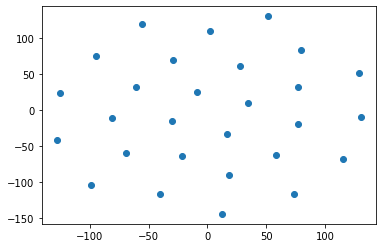

In [80]:
plt.scatter(df.x, df.y);

Converting text to vectors 

Word2vec

In [ ]:
# Importing necessary libraries

import gensim

from gensim.models import Word2Vec

from tqdm import tqdm

from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Words list

words_list = []

# looping through to append words
for index in range(len(sentences)):
  words_list.append(nltk.word_tokenize(sentences[index]))

print(len(words_list)," length of sentences")

8349  length of sentences


In [ ]:
empty_lists = []

for i,wl in enumerate(words_list):
  if not wl:
    empty_lists.append(i)

print("The number of empty lists are: ", len(empty_lists))

The number of empty lists are:  2


Since there are 21 empty lists. We will combine them with the labels and drop the 21 rows

In [ ]:
# Let us combine the dataset and get rid of any null values that may have occured after preprocessing

preprocessed_data = pd.concat([pd.DataFrame(np.array(words_list)),pd.DataFrame(data['sentiment'])], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Checking for null values 

preprocessed_data.isna().any()

0            False
sentiment    False
dtype: bool

In [ ]:
# We have empty lists that we have to get rid of and we have the indexes of those lists store in empty_lists list

# Verifying elemnts from the list

for indexes in empty_lists:
  print(preprocessed_data.iloc[indexes,0])

[]
[]


There we go, our empty lists. 

In [ ]:
preprocessed_data.drop(empty_lists, axis=0, inplace=True)

In [ ]:
word_lists = [lists for lists in preprocessed_data.iloc[:,0]]

In [ ]:
model = gensim.models.Word2Vec(words_list, window=5, min_count = 2)

In [ ]:
# Empty list 
X = []

# Looping though words
for words in tqdm(word_lists):
  X.append(np.mean([model.wv[word] for word in words if word in model.wv.index2word], axis=0))

  0%|          | 0/8347 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 8347/8347 [00:01<00:00, 4737.44it/s]


In [ ]:
# Coverting them to arrays

X = np.array(X)
y = preprocessed_data['sentiment']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
y = p_data['sentiment']

In [54]:
labels = []
corresponding_num = []

for ind,lab in enumerate(y.unique()):
  labels.append(lab)
  corresponding_num.append(ind)

In [55]:
encodings = [val for val in y]

In [56]:


for i,value in enumerate(encodings):
  for ind,unique in enumerate(labels):
    if value==unique:
      encodings[i] = ind

In [57]:

encodings = np.array(encodings)

In [58]:



y = encodings

Checking types

In [ ]:
# Converting all the arrays to same data type

X = np.array([val.astype(np.float64) for val in X])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


Checking for null values in the array

In [ ]:
pd.DataFrame(X).isna().sum()

0    75
dtype: int64

Found 227 null values

In [ ]:
# Let us combine the dataset and get rid of any null values that may have occured after preprocessing

vector_data = pd.concat([pd.DataFrame(X),pd.DataFrame(y)], axis=1)

In [ ]:
vector_data.head()

,0,0
0,"[0.5185931921005249, -0.2783828675746918, -0.1...",0
1,"[0.3185077905654907, -0.1711403876543045, -0.1...",1
2,"[0.39131638407707214, -0.21000224351882935, -0...",2
3,"[0.24084103107452393, -0.13017770648002625, -0...",1
4,"[0.23725177347660065, -0.12525340914726257, -0...",3


In [ ]:
vector_data.isna().any()

0     True
0    False
dtype: bool

Dropping all the null values

In [ ]:
vector_data.dropna(inplace=True)

In [ ]:
vector_data.shape

(8272, 2)

In [ ]:
X = np.array([feat for feat in vector_data.iloc[:,0]])
y = np.array([label for label in vector_data.iloc[:,1]])

In [ ]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X,y, train_size = 0.93, random_state= 12)

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
gnb = GaussianNB()

gnb.fit(train_X, train_y)

GaussianNB()

In [ ]:
predictions = gnb.predict(test_X)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
score = accuracy_score(test_y, predictions)

In [ ]:
print("And the final score is ...... ..... ...", score)

And the final score is ...... ..... ... 0.11896551724137931


In [ ]:
train_X.shape

(7692, 100)

In [ ]:
train_y.shape

(7692,)

In [ ]:
for v in range(len(vectors[:10])):
  print(vectors[v].shape)

(8, 300)
(7, 300)
(3, 300)
(15, 300)
(5, 300)
(8,)
(8, 300)
(7, 300)
(3, 300)
(15, 300)


In [ ]:
vectors[4]

array([[-0.13769531,  0.03540039,  0.59765625, ..., -0.22167969,
        -0.20800781,  0.00340271],
       [-0.21875   ,  0.08154297,  0.29492188, ..., -0.5078125 ,
         0.02172852, -0.11669922],
       [ 0.04785156, -0.26757812,  0.07324219, ..., -0.27148438,
        -0.06542969,  0.328125  ],
       [-0.04785156,  0.16699219,  0.078125  , ..., -0.29101562,
         0.04467773,  0.16113281],
       [ 0.08154297, -0.06396484,  0.02526855, ..., -0.14160156,
        -0.05395508, -0.07666016]], dtype=float32)

Converting to categories

In [ ]:
from keras.utils import to_categorical

In [ ]:
train_y = to_categorical(train_y,13)

In [ ]:
# Covertiing test_y to binary 
test_y = to_categorical(test_y,13)

## TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer()

In [ ]:
p_data.head()

,Content,sentiment
0,supersense ooooo explanation thank god u would...,love
1,last day senior bye bff,sadness
2,noiselesssound heard regina girl song le deux ...,sadness
3,someone said wolverine feel like watching x me...,fun
4,shanselman still class loader even custom asse...,empty


In [ ]:
X = p_data['Content']
y= p_data["sentiment"]

In [ ]:
labels = []
corresponding_num = []

encodings = [val for val in y]

for ind,lab in enumerate(y.unique()):
  labels.append(lab)
  corresponding_num.append(ind)

for i,value in enumerate(encodings):
  for ind,unique in enumerate(labels):
    if value==unique:
      encodings[i] = ind

encodings = np.array(encodings)

y = encodings

In [ ]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y , test_size=0.11, random_state=10)

In [ ]:
train_sent = [sent for sent in train_X]
test_sent = [sent for sent in test_X]

In [ ]:
train_X = vectorizer.fit_transform(train_sent)
test_X = vectorizer.transform(test_sent)

In [ ]:
sentences[0]

'supersense ooooo explanation thank god u would forever wondering love good night mare tho'

In [ ]:
# Covertiing test_y to binary 
from keras.utils import to_categorical


train_y = to_categorical(train_y,13)

In [ ]:
test_y = to_categorical(test_y,13)

In [ ]:
train_X.shape

(7430, 13539)

## LSTM RNN MODEL

Implementing Bi-directional Long short term Memory recurrent neural network 

In [ ]:
# Importing the necessary libraries

import tensorflow 
from tensorflow import keras

from keras.layers import Dense, Flatten, Input, LSTM, Bidirectional, Embedding, Dropout, CuDNNLSTM, GRU
from keras.models import Model, Sequential

In [ ]:
train_X.shape[1:]

(27, 100)

The fluctuations are normal within certain limits and depend on the fact that you use a heuristic method but in your case they are excessive. Despite all the performance takes a definite direction and therefore the system works. From the graphs you have posted, the problem depends on your data so it's a difficult training. If you have already tried to change the learning rate try to change training algorithm. You would agree to test your data: first compute the Bayes error rate using a KNN (use the trick regression in case you need), in this way you can check whether the input data contain all the information you need. Then try the LSTM without the validation or dropout to verify that it has the ability to achieve the result for you necessary. If the training algorithm is not suitable you should have the same problems even without the validation or dropout. Just at the end adjust the training and the validation size to get the best result in the test set. Statistical learning theory is not a topic that can be talked about at one time, we must proceed step by step.


source :https://stats.stackexchange.com/questions/345990/why-does-the-loss-accuracy-fluctuate-during-the-training-keras-lstm

In [ ]:
input = Input(shape=(27,100))
lstm = CuDNNLSTM(3, return_sequences=True)(input)
dropout = Dropout(0.2)(lstm)
lstm2 = CuDNNLSTM(3, return_sequences=True)(dropout)
dropout2 = Dropout(0.2)(lstm2)
flatten= Flatten()(dropout2)
prediction = Dense(13, activation="softmax")(flatten)

In [ ]:
# Model

model = Model(inputs = input, outputs = prediction)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 27, 100)]         0         
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 27, 3)             1260      
                                                                 
 dropout (Dropout)           (None, 27, 3)             0         
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 27, 3)             96        
                                                                 
 dropout_1 (Dropout)         (None, 27, 3)             0         
                                                                 
 flatten (Flatten)           (None, 81)                0         
                                                                 
 dense (Dense)               (None, 13)                1066  

In [ ]:
# Setting the learning rate for the optimizer. 

adam_optimizer = keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)

# Compiling the model

model.compile(optimizer=adam_optimizer, loss="categorical_crossentropy", metrics="accuracy")

Keras callbacks

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
patience = EarlyStopping(patience=200)

save_best = ModelCheckpoint("lstm_model.h5", save_best_only=True)

In [ ]:
train_X.shape

(7096, 27, 100)

In [ ]:
train_y.shape

(7096, 13)

In [ ]:
test_X.shape

(1253, 27, 100)

In [ ]:
test_y.shape

(1253, 13)

In [ ]:
model.fit(train_X, train_y, validation_data=(test_X,test_y),epochs=1000,callbacks=[save_best, patience])

Epoch 1/1000
222/222 [==============================] - 5s 8ms/step - loss: 2.4532 - accuracy: 0.0912 - val_loss: 2.4044 - val_accuracy: 0.1093
Epoch 2/1000
222/222 [==============================] - 1s 7ms/step - loss: 2.4146 - accuracy: 0.0889 - val_loss: 2.4054 - val_accuracy: 0.0998
Epoch 3/1000
222/222 [==============================] - 1s 7ms/step - loss: 2.4087 - accuracy: 0.0933 - val_loss: 2.3998 - val_accuracy: 0.0862
Epoch 4/1000
222/222 [==============================] - 1s 7ms/step - loss: 2.4040 - accuracy: 0.0908 - val_loss: 2.3970 - val_accuracy: 0.1014
Epoch 5/1000
222/222 [==============================] - 2s 7ms/step - loss: 2.4019 - accuracy: 0.0971 - val_loss: 2.3926 - val_accuracy: 0.1101
Epoch 6/1000
222/222 [==============================] - 2s 7ms/step - loss: 2.3975 - accuracy: 0.1022 - val_loss: 2.3875 - val_accuracy: 0.1133
Epoch 7/1000
222/222 [==============================] - 1s 7ms/step - loss: 2.3931 - accuracy: 0.1064 - val_loss: 2.3838 - val_accuracy:

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
predictions = model.predict(test_X)

40/40 [==============================] - 0s 5ms/step


In [ ]:
pred = []

for yhat in predictions:
  pred.append(np.argmax(yhat))

In [ ]:
actual = []

for y in test_y:
  actual.append(np.argmax(y))

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(actual, pred)

0.16600159616919394